# Transfer Learning

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Cats vs Dogs

In [19]:
(train_ds, test_ds), ds_info = tfds.load('cats_vs_dogs', as_supervised=True,with_info=True,split=['train[:90%]', 'train[90%:]'],)

## Визуализация датасета

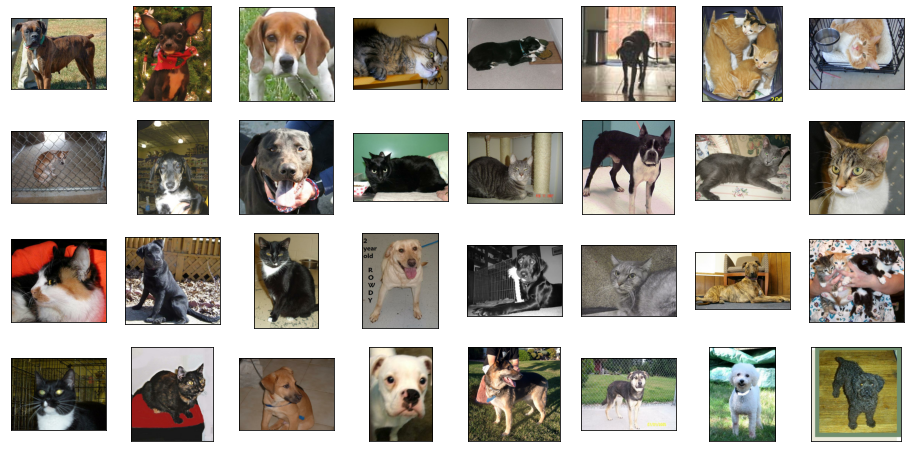

In [20]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [21]:
INP_SIZE = 160
NUM_EPOCHS = 3
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

# Подготовка модели CNN

In [22]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Дообучение весов предобученной модели
# base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

## Подготовка к обучению

In [23]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Model Summary

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [25]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/3
654/654 [==============================] - 197s 231ms/step - loss: 0.0807 - accuracy: 0.9682 - val_loss: 0.0843 - val_accuracy: 0.9813
Epoch 2/3
654/654 [==============================] - 147s 223ms/step - loss: 0.0267 - accuracy: 0.9902 - val_loss: 0.1289 - val_accuracy: 0.9813
Epoch 3/3
654/654 [==============================] - 146s 222ms/step - loss: 0.0138 - accuracy: 0.9949 - val_loss: 0.0763 - val_accuracy: 0.9835
CPU times: user 9min 29s, sys: 34.5 s, total: 10min 3s
Wall time: 9min


## Оценка качества модели

In [26]:
%%time

model.evaluate(test_ds)

18/18 [==============================] - 6s 293ms/step - loss: 0.0763 - accuracy: 0.9835
CPU times: user 10.9 s, sys: 706 ms, total: 11.6 s
Wall time: 10.3 s


[0.07634003460407257, 0.9835069179534912]

## Запуск предсказания

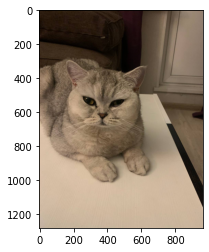

In [28]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)


img = imageio.imread('image.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [30]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: ' + ds_info.features['label'].int2str(pred_label))

Prediction: cat
